<link href="https://cdn.jsdelivr.net/npm/bootstrap@5.0.2/dist/css/bootstrap.min.css" rel="stylesheet">
<div style="" class="bg-success btn btn-success w-100"><h1>Predicting Formal Credit Uptake Among Rwandan Tea Farmers Using Machine Learning</h1>
<hr>
Pierre Celestin Niyomugabo - 100883
<hr>
</div>

<link href="https://cdn.jsdelivr.net/npm/bootstrap@5.0.2/dist/css/bootstrap.min.css" rel="stylesheet">
<div class="btn btn-warning w-100 text-left text-start"><h2>Step 1: Load important packages</h2></div>

In [393]:
import pandas as pd
import numpy as np
from scipy.stats import chisquare
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
# from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns
import shap
import statsmodels.api as sm



<link href="https://cdn.jsdelivr.net/npm/bootstrap@5.0.2/dist/css/bootstrap.min.css" rel="stylesheet">
<div class="btn btn-warning w-100 text-left text-start"><h2>Step 2: Import the dataset</h2></div>

In [394]:
data = pd.read_csv('dataset.csv', encoding="latin", low_memory=False)
data.head()
data.Enumerator.unique()
print(data.count())

start             808
end               808
Enumerator        808
cal_enumerator    808
note1               0
                 ... 
_status           808
_submitted_by     757
__version__       808
_tags               0
_index            808
Length: 131, dtype: int64


<link href="https://cdn.jsdelivr.net/npm/bootstrap@5.0.2/dist/css/bootstrap.min.css" rel="stylesheet">
<div class="btn btn-warning w-100 text-left text-start"><h2>Step 3: Dataset inspection and data pre-processing</h2></div>

In [395]:
# 1. Drop unnecessary columns
print("Columns:", data.columns.tolist())
columns_to_trop = ['Enumerator', 'cal_enumerator', 'farmer_name', 'entity_name', '_submitted_by'] # I selected these as variables that include names
columns_to_trop.extend([col for col in data.columns if 'note' in col.lower()]) # I also need to drop those columns containing "notes"
columns_to_trop.extend([col for col in data.columns if 'Geolocation' in col.lower()]) # I also need to drop those columns containing "Geolocation" as it's sensitive info
print(f"Columns to drop: {len(columns_to_trop)} columns\n", columns_to_trop)
data.drop(columns=columns_to_trop, inplace=True, errors='ignore')


# 2. Inspect and handle duplicates if any (based on _uuid)
print(f"Duplicates: {data.duplicated(subset=['_uuid']).sum()}")

Columns: ['start', 'end', 'Enumerator', 'cal_enumerator', 'note1', 'consent', 'interview_date', 'Province', 'cal_province', 'District', 'cal_district', 'Sector', 'farmer_name', 'type', 'cal_type', 'entity_name', 'sex', 'dob', 'dob_year', 'interview_year', 'age', 'age_note', 'education', 'hh_size', 'income1', 'income2', 'tea_area', 'tea_income', 'annual_tea_income', 'formal_credit', 'formal_credit_count', 'lender_institution_type', 'other_lender_institution_type', 'formal_credit_size', 'formal_payback_period', 'formal_interest_rate', 'formal_defaulted', 'formal_defaulted_type', 'formal_defaulted_reason', 'formal_defaulted_reason/1', 'formal_defaulted_reason/2', 'formal_defaulted_reason/3', 'formal_defaulted_reason/4', 'formal_defaulted_reason/5', 'formal_defaulted_reason/99', 'formal_defaulted_reason_other', 'informal_credit', 'informal_credit_count', 'informal_institution_type', 'other_informal_institution_type', 'informal_credit_size', 'informal_payback_period', 'informal_interest_rat

## 1. Defining labels for multiple reponses variables
1. Reasons for defaulting formal credit

In [396]:
formal_defaulted_reason = {
    'formal_defaulted_reason1': "Economic disruption",
    'formal_defaulted_reason2': "Financial loss",
    'formal_defaulted_reason3': "COVID-19 pandemic",
    'formal_defaulted_reason4': "High rate of interest",
    'formal_defaulted_reason5': "Health conditions worsen",
    'formal_defaulted_reason99': "Other"
}

2. Reasons for defaulting informal credit

In [397]:
informal_defaulted_reason = {
    'informal_defaulted_reason1': "Economic disruption",
    'informal_defaulted_reason2': "Financial loss",
    'informal_defaulted_reason3': "COVID-19 pandemic",
    'informal_defaulted_reason4': "High rate of interest",
    'informal_defaulted_reason5': "Health conditions worsen",
    'informal_defaulted_reason99': "Other"
}

3. Preference of formal credit over informal credit

In [398]:
motivation_for_formal_loans = {
    'formal_motivation1': "Affordable interest rate",
    'formal_motivation2': "High capital amount is granted",
    'formal_motivation3': "Confidentiality/professionalism",
    'formal_motivation4': "Transparency",
    'formal_motivation5': "They help us with project plan",
    'formal_motivation6': "Granted in short time",
    'formal_motivation7': "Long payback period granted",
    'formal_motivation8': "Collateral not needed",
    'formal_motivation9': "None",
    'formal_motivation99': "Other"
}

4. Preference of informal credit over formal credit

In [399]:
motivation_for_informal_loans = {
    'informal_motivation1': "Affordable interest rate",
    'informal_motivation2': "High capital amount is granted",
    'informal_motivation3': "Confidentiality/professionalism",
    'informal_motivation4': "Transparency",
    'informal_motivation5': "They help us with project plan",
    'informal_motivation6': "Granted in short time",
    'informal_motivation7': "Long payback period granted",
    'informal_motivation8': "Collateral not needed",
    'informal_motivation9': "None",
    'informal_motivation99': "Other"
}

5. Challenges that inhibited the farmer to take credit

In [400]:
challenges_to_credit = {
    'challenges_to_credit1': "Lack of required collateral",
    'challenges_to_credit2': "Your credit score was too low.",
    'challenges_to_credit3': "Debt-to-income ratio was too high",
    'challenges_to_credit4': "You tried to borrow too much",
    'challenges_to_credit5': "Your income was insufficient or unstable",
    'challenges_to_credit6': "Your loan purpose didn't meet the lender's criteria",
    'challenges_to_credit7': "Your application was missing information",
    'challenges_to_credit99': "Other"
}

6. Reasons to not apply/request credit

In [401]:
reasons_to_not_apply = {
    'reasons_to_not_apply1': "I didn't need credit at all",
    'reasons_to_not_apply2': "Lack of information about credit/procedures",
    'reasons_to_not_apply3': "Lack of skills on credit management",
    'reasons_to_not_apply4': "Lack of collateral",
    'reasons_to_not_apply5': "Lack of lender",
    'reasons_to_not_apply99': "Other"
}

## 2. Drop irrelevant observations

In [402]:
data = data[data['consent'] == 1] # keep only those who consent to participte
data = data[data['age'] >= 18] # it was decided prior that only those aged 18 and above will be considered for the study
data = data[((data['formal_credit'] == 0) | ((data['formal_interest_rate'].astype(float) >= 6.5) & (data['formal_interest_rate'].astype(float) <=36)))] # the rate can not be less than BNR lower limit
data = data[data['sex'].isin([1,2])] # I want to keep only distinct sex (male and female)
data = data[~((data['hh_size'] > 12) & (data['type'] == 1))]
data = data[((data['formal_credit'] == 0) | (data['formal_credit_size'] >=30000))]
data = data[((data['informal_credit'] == 0) | (data['informal_credit_size'] >=2000))]
data = data[(data['formal_credit'] == 1) | (data['informal_credit'] == 1)]
data = data[
    ((data['formal_payback_period'] <= 60) | data['formal_payback_period'].isna()) &
    ((data['informal_payback_period'] <= 60) | data['informal_payback_period'].isna())
]
df = data[(data['informal_interest_rate'].isna()) | (data['informal_interest_rate'] <= 120)]

print(f"Observations: {len(data)}")

Observations: 622


## 3. Generate a new variable (evertook credit)

In [403]:
data['credit'] = ((data['formal_credit'] == 1) | (data['informal_credit'] == 1)).astype(int)
yesorno = {1: 'Yes', 0: 'No'}
data['credit_label'] = data['credit'].map(yesorno)

# credit formal = Formal, Informal, Both, None
data['credit_source'] = np.select(
    [
        (data['formal_credit'] == 1) & (data['informal_credit'] == 1),
        (data['formal_credit'] == 1) & (data['informal_credit'] == 0),
        (data['formal_credit'] == 0) & (data['informal_credit'] == 1),
        (data['formal_credit'] == 0) & (data['informal_credit'] == 0)
    ],
    [
        'Both',
        'Formal',
        'Informal',
        'None'
    ],
    default='Unknown'
)


## 4. Generate categorical variables

In [404]:
# Age category
data['age_cat'] = pd.cut(
    data['age'],
    bins=[17, 50, float('inf')],
    labels=["18-50", "Above 50"]
)

# Tea area
data['tea_area_cat'] = pd.cut(
    data['tea_area'],
    bins=[0.0001, 0.5, 1, 1.5, float('inf')],
    labels=[
        "Less than 0.5 ha",
        "0.5 - 1 ha",
        "1-1.5 ha",
        "Above 1.5 ha"
    ]
)

# Formal credit counts
data['formal_credit_count_cat'] = pd.cut(
    data['formal_credit_count'],
    bins=[0, 1, 2, 3, 99],
    labels=["One", "Two", "Three", "More than 3"]
)

# Formal credit size
data['formal_credit_size_cat'] = pd.cut(
    data['formal_credit_size'],
    bins=[0, 200000, 500000, float('inf')],
    labels=[
        "Less than 200,000",
        "200,000-500,000",
        "Above 500,000"
    ]
)

# Informal credit size
data['informal_credit_size_cat'] = pd.cut(
    data['informal_credit_size'],
    bins=[-0.01, 50000, 100000, float('inf')],
    labels=[
        "Less than 50,000",
        "50,000-100,000",
        "Above 100,000"
    ]
)

# HH size
data['hh_size_cat'] = pd.cut(
    data['hh_size'],
    bins=[0, 3, 99],
    labels=["1-3", "4+"]
)

# Informal credit count
data['informal_credit_count_cat'] = pd.cut(
    data['informal_credit_count'],
    bins=[0, 1, 2, 3, 99],
    labels=["One", "Two", "Three", "More than 3"]
)

# Formal credit payback
data['formal_payback_period_cat'] = pd.cut(
    data['formal_payback_period'],
    bins=[0, 12, 24, 36, 99],
    labels=[
        "1-12 months", "13-24 months", "25-36 months", "More than 36 months"
    ]
)

# Informal credit payback
data['informal_payback_period_cat'] = pd.cut(
    data['informal_payback_period'],
    bins=[0, 12, 24, 36, 99],
    labels=[
        "1-12 months", "13-24 months", "25-36 months", "More than 36 months"
    ]
)

# Educated or not
data['educated'] = data['education'].apply(
    lambda x: "Not educated" if x == 1 else "Educated"
)

# Distance to financial institution
data['distance_cat'] = pd.cut(
    data['distance_to_credit_facility'],
    bins=[-0.01, 1, 5, float('inf')],
    labels=[
        "Less than 1km", "1-5 km", "Above 5km"
    ]
)

<link href="https://cdn.jsdelivr.net/npm/bootstrap@5.0.2/dist/css/bootstrap.min.css" rel="stylesheet">
<div class="btn btn-warning w-100 text-left text-start"><h2>Step 4: Exploratory Data Analysis (EDA)</h2></div>

## 1. Credit source

In [405]:
credit_source_counts = data['credit_source'].value_counts(dropna=False)
credit_source_percent = data['credit_source'].value_counts(normalize=True, dropna=False) * 100

credit_source_table = pd.DataFrame({
    'Count': credit_source_counts,
    'Percent': credit_source_percent.round(2)
}).reset_index().rename(columns={'index': 'Credit Source'})

# Chi-Square Goodness-of-Fit test 
observed = credit_source_counts.values
expected = [sum(observed) / len(observed)] * len(observed) 

chi2_stat, p_value = chisquare(f_obs=observed, f_exp=expected)

# Display result
display(credit_source_table)
print(f"Chi-Square Test: χ² = {chi2_stat:.2f}, p-value = {p_value:.4f}")


,credit_source,Count,Percent
0,Informal,314,50.48
1,Both,167,26.85
2,Formal,141,22.67


Chi-Square Test: χ² = 83.95, p-value = 0.0000


## 2. Demographics

In [406]:
import pandas as pd
from scipy.stats import chi2_contingency

def format_demographic_table(df, variables, target):
    table_rows = []

    for var in variables:
        # Generate cross-tab: 1 = Formal, 0 = Informal
        ctab = pd.crosstab(df[var], df[target])
        ctab_perc = ctab.div(ctab.sum(axis=1), axis=0).fillna(0) * 100

        # Chi-square test
        chi2, p, dof, expected = chi2_contingency(ctab)

        for level in ctab.index:
            formal = 1
            informal = 0

            # Add missing columns if needed
            for col in [formal, informal]:
                if col not in ctab.columns:
                    ctab[col] = 0
                    ctab_perc[col] = 0.0

            # Reorder to avoid KeyError
            ctab = ctab[[formal, informal]]
            ctab_perc = ctab_perc[[formal, informal]]

            row = {
                'Variable/category': f"  {level}",
                'Formal n (%)': f"{ctab.loc[level].get(formal, 0)} ({ctab_perc.loc[level].get(formal, 0):.1f}%)",
                'Informal n (%)': f"{ctab.loc[level].get(informal, 0)} ({ctab_perc.loc[level].get(informal, 0):.1f}%)",
                'Total n (%)': f"{ctab.loc[level].sum()} ({(ctab.loc[level].sum() / len(df) * 100):.1f}%)",
                'chi2': '',
                'p-value': '',
            }
            table_rows.append(row)

        # Add total row
        total_counts = ctab.sum()
        total_row = {
            'Variable/category': '  Total',
            'Formal n (%)': f"{total_counts.get(1, 0)} (100%)",
            'Informal n (%)': f"{total_counts.get(0, 0)} (100%)",
            'Total n (%)': f"{total_counts.sum()} (100%)",
            'chi2': f"chi2: {chi2:.1f},\np: {p:.3f},\ndf: {dof}",
            'p-value': f"{p:.3f}"
        }
        table_rows.append(total_row)

        # Add spacing row
        table_rows.append({col: '' for col in total_row})

    return pd.DataFrame(table_rows)


# Usage:

variables = ['sex', 'distance_cat', 'educated', 'tea_area_cat', 'age_cat',
    'formal_credit_size_cat', 'informal_credit_size_cat', 'hh_size_cat',
    'formal_credit_count_cat', 'informal_credit_count_cat',
    'formal_payback_period_cat', 'informal_payback_period_cat', 'cal_district'
]


demographics_table = format_demographic_table(data, variables, 'formal_credit')
demographics_table.to_csv('demographics_table.csv', index=False)
demographics_table.head(10)


,Variable/category,Formal n (%),Informal n (%),Total n (%),chi2,p-value
0,1.0,190 (52.3%),173 (47.7%),363 (58.4%),,
1,2.0,118 (45.6%),141 (54.4%),259 (41.6%),,
2,Total,308 (100%),314 (100%),622 (100%),"chi2: 2.5,\np: 0.113,\ndf: 1",0.113
3,,,,,,
4,Less than 1km,51 (48.1%),55 (51.9%),106 (17.0%),,
5,1-5 km,195 (45.8%),231 (54.2%),426 (68.5%),,
6,Above 5km,62 (68.9%),28 (31.1%),90 (14.5%),,
7,Total,308 (100%),314 (100%),622 (100%),"chi2: 16.0,\np: 0.000,\ndf: 2",0.000
8,,,,,,
9,Educated,235 (50.3%),232 (49.7%),467 (75.1%),,


<link href="https://cdn.jsdelivr.net/npm/bootstrap@5.0.2/dist/css/bootstrap.min.css" rel="stylesheet">
<div class="btn btn-warning w-100 text-left text-start"><h2>Step 5: Modelling</h2></div>

## 1. Feature selection

In [407]:
selected_features = [
    'type', 'education', 'age', 'tea_area',
    'annual_tea_income', 'formal_payback_period',
    'formal_credit_size', 'collateral_requested',
    'access_to_training', 'hh_size'
]


available_features = [feat for feat in selected_features if feat in data.columns]
df_model = data[available_features + ['formal_credit']].dropna(subset=['formal_credit'])

## 2. Handle missing values

In [408]:
for col in df_model.columns:
    if df_model[col].dtype in [np.float64, np.int64]:
        df_model[col] = df_model[col].fillna(df_model[col].median())
    else:
        df_model[col].fillna(df_model[col].mode()[0], inplace=True)

## 3. Encode categorical variables

In [409]:
label_encoders = {}
for col in df_model.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col])
    label_encoders[col] = le

## 4. Prepare X and y

In [410]:
X = df_model.drop(columns=['formal_credit'])
y = df_model['formal_credit']
feature_names = X.columns.tolist() 

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## 5. Train-test split

In [411]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.value_counts(), y_test.value_counts()

((497, 10),
 (125, 10),
 formal_credit
 0    249
 1    248
 Name: count, dtype: int64,
 formal_credit
 0    65
 1    60
 Name: count, dtype: int64)

## 6. Modelling

In [412]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Support Vector Machine": SVC(kernel='rbf', probability=True),
    # "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    "Neural Network":  MLPClassifier(hidden_layer_sizes=(10,), activation='relu', solver='adam', max_iter=1000, random_state=42)
}


# Store results
results = []

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.append({
        "Model": name,
        "Accuracy": round(acc, 3),
        "Precision": round(prec, 3),
        "Recall": round(rec, 3),
        "F1 Score": round(f1, 3)
    })

# Convert to DataFrame for display
results= pd.DataFrame(results)

In [413]:
# Regression

# Coefficients from logistic regression
X_train_df = pd.DataFrame(X_train, columns=feature_names)

# Add constant (intercept term)
X_train_df = sm.add_constant(X_train_df)

# Fit logistic regression
logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit(disp=False)

# Extract coefficients and p-values
coeff_df = pd.DataFrame({
    "Feature": result.params.index,
    "Coefficient": result.params.values,
    "P-value": result.pvalues.values
}).sort_values(by="Coefficient", ascending=False)


coeff_df

,Feature,Coefficient,P-value
7,x8,1.607935,0.286533
6,x7,0.864142,0.000181
8,x9,0.473984,0.000038
4,x5,0.305329,0.006923
2,x3,0.294991,0.006508
3,x4,0.184645,0.098920
9,x10,0.160863,0.111777
1,x2,0.089822,0.447537
0,x1,0.086525,0.401510
5,x6,-0.191723,0.144312


In [414]:
importances = models["Random Forest"].feature_importances_
feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)
feature_importance_df

,Feature,Importance
6,formal_credit_size,0.500032
5,formal_payback_period,0.359173
3,tea_area,0.054376
2,age,0.026946
4,annual_tea_income,0.019551
8,access_to_training,0.015711
9,hh_size,0.015260
1,education,0.008126
0,type,0.000680
7,collateral_requested,0.000145


## 7. Model Results

In [415]:
# Print model results
results

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.672,0.686,0.583,0.631
1,Random Forest,0.992,1.000,0.983,0.992
2,Support Vector Machine,0.800,0.818,0.750,0.783
3,Neural Network,0.976,1.000,0.950,0.974


## 8. Confusion Matrix

In [416]:
# Confusion matrices
conf_matrices = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    conf_matrices[name] = cm

conf_matrices

{'Logistic Regression': array([[49, 16],
        [25, 35]]),
 'Random Forest': array([[65,  0],
        [ 1, 59]]),
 'Support Vector Machine': array([[55, 10],
        [15, 45]]),
 'Neural Network': array([[65,  0],
        [ 3, 57]])}

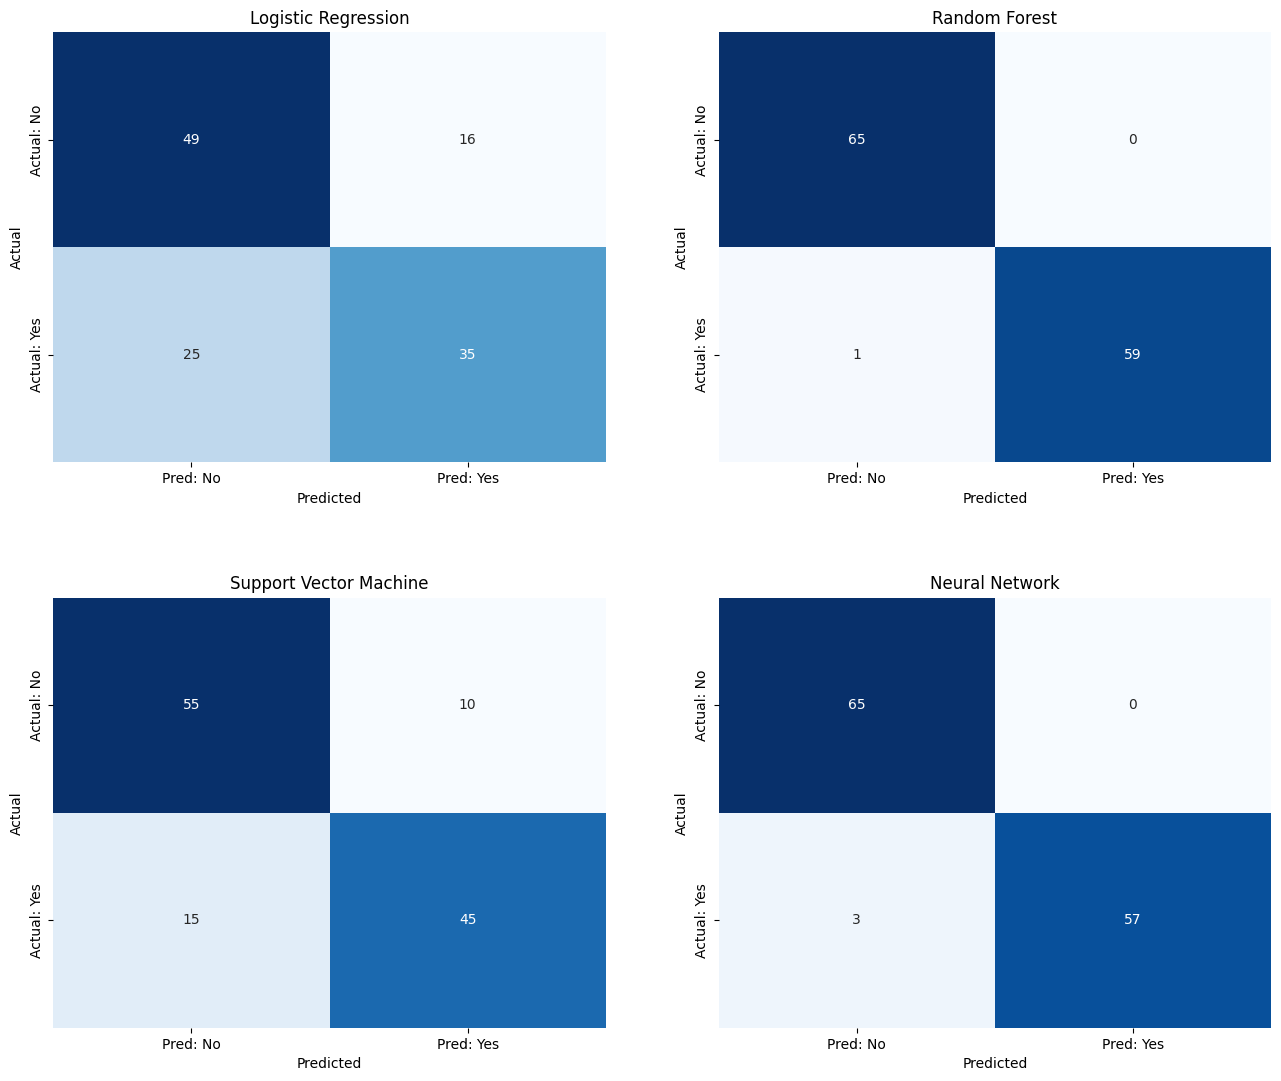

In [417]:
# Plot confusion matrices
def plot_conf_matrix(cm, title, ax):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=["Pred: No", "Pred: Yes"],
                yticklabels=["Actual: No", "Actual: Yes"],
                ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

fig, axes = plt.subplots(2, 2, figsize=(14, 12), facecolor='white')

model_names = list(conf_matrices.keys())

for i, ax in enumerate(axes.flat):
    plot_conf_matrix(conf_matrices[model_names[i]], model_names[i], ax)

# Add a white border line between top and bottom rows
for ax in axes[0]:
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['bottom'].set_color("white")
for ax in axes[1]:
    ax.spines['top'].set_linewidth(3)
    ax.spines['top'].set_color("white")

plt.tight_layout(pad=5.0)
# plt.show()
plt.savefig('confusion_matrices.png', bbox_inches='tight', dpi=300)